In [1]:
import timm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

from timm.models.layers import trunc_normal_

def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

class DecoderLinear(nn.Module):
    def __init__(self, n_cls, patch_size, d_encoder):
        super().__init__()

        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_encoder, n_cls)
        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size
        x = self.head(x)
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class Segmenter(nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        n_cls,
    ):
        super().__init__()
        self.n_cls = n_cls
        self.encoder = encoder
        self.decoder = decoder

    @torch.jit.ignore
    def no_weight_decay(self):
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params

    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        H, W = im.size(2), im.size(3)

        #x = self.encoder(im, return_features=True)
        x = self.encoder.forward_features(im)
        

        # remove CLS/DIST tokens for decoding
        #num_extra_tokens = 1 + self.encoder.distilled
        #x = x[:, num_extra_tokens:]
        x = x[:,self.encoder.num_prefix_tokens:,...]

        masks = self.decoder(x, (H, W))

        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        #masks = unpadding(masks, (H_ori, W_ori))

        return masks

#    def get_attention_map_enc(self, im, layer_id):
#        return self.encoder.get_attention_map(im, layer_id)
#
#    def get_attention_map_dec(self, im, layer_id):
#        x = self.encoder(im, return_features=True)
#
#        # remove CLS/DIST tokens for decoding
#        num_extra_tokens = 1 + self.encoder.distilled
#        x = x[:, num_extra_tokens:]
#
#        return self.decoder.get_attention_map(x, layer_id)
    
encoder = timm.create_model('vit_base_patch8_224.dino', pretrained=True, dynamic_img_size=True)
decoder = DecoderLinear(n_cls=10, d_encoder=encoder.embed_dim, patch_size=8)
model = Segmenter(encoder,decoder,n_cls=10)

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import numpy as np

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image2 = torch.clone(image)
        if len(image2.shape) == 4:
            # batched
            image2 = image2.permute(1, 0, 2, 3)
        for t, m, s in zip(image2, self.mean, self.std):
            t.mul_(s).add_(m)
        return image2.permute(1, 0, 2, 3)
    
norm = v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

class TorchPCA(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = X.mean(dim=0)
        unbiased = X - self.mean_.unsqueeze(0)
        U, S, V = torch.pca_lowrank(unbiased, q=self.n_components, center=False, niter=4)
        self.components_ = V.T
        self.singular_values_ = S
        return self

    def transform(self, X):
        t0 = X - self.mean_.unsqueeze(0)
        projected = t0 @ self.components_.T
        return projected


def pca(image_feats_list, dim=3, fit_pca=None, max_samples=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_pca is None:
            tensor = F.interpolate(tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return tensor.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_pca is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    # Subsample the data if max_samples is set and the number of samples exceeds max_samples
    if max_samples is not None and x.shape[0] > max_samples:
        indices = torch.randperm(x.shape[0])[:max_samples]
        x = x[indices]

    if fit_pca is None:
        fit_pca = TorchPCA(n_components=dim).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        x_red = fit_pca.transform(flatten(feats))
        if isinstance(x_red, np.ndarray):
            x_red = torch.from_numpy(x_red)
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(device))

    return reduced_feats, fit_pca

from pytorch_lightning import seed_everything

def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])


def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

In [29]:
from dl_toolbox.datasets import Rellis3d

tf = v2.Compose([
    v2.RandomCrop(size=(640, 640)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rellis = '/data/Rellis-3D'
imgs = [rellis+'/00000/pylon_camera_node/frame000000-1581624652_750.jpg']
msks = [rellis+'/00000/pylon_camera_node_label_id/frame000000-1581624652_750.png']
dataset = Rellis3d(
    imgs=imgs,
    msks=msks,
    merge='all19',
    transforms=tf
)
elem = dataset[0]
image, mask = elem['image'].to(device).unsqueeze(0), elem['label']
h = 640 // 8
w = 640 // 8
encoder.to(device)
lr_feats = encoder.forward_features(image)
lr_feats = lr_feats[:,encoder.num_prefix_tokens:,...]
lr_feats = lr_feats.reshape(-1, h, w, 768).permute(0,3,1,2).detach().cpu()
hr_feats_bili = v2.functional.resize(lr_feats, (640, 640), Image.BILINEAR)

In [35]:
from concurrent.futures import ProcessPoolExecutor

ref = image[0].permute(1,2,0).to('cpu').numpy()
source_upsampled = hr_feats_bili[0].permute(1,2,0).to('cpu').numpy()
print(reference.shape, source_upsampled.shape)

NB_CHANNELS = 768

scale = 80 / 640
radius = 2
diameter = 2 * radius + 1
step = int(np.ceil(1 / scale))
padding = radius * step
sigma_spatial = 2.5
sigma_range = np.std(reference)

reference = np.pad(ref, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)
source_upsampled = np.pad(source_upsampled, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)

# Spatial Gaussian function.
x, y = np.meshgrid(np.arange(diameter) - radius, np.arange(diameter) - radius)
kernel_spatial = np.exp(-1.0 * (x**2 + y**2) /  (2 * sigma_spatial**2))
#kernel_spatial = np.repeat(kernel_spatial, 3).reshape(-1, 3)
kernel_spatial = np.reshape(-1,1)

# Lookup table for range kernel.
lut_range = np.exp(-1.0 * np.arange(256)**2 / (2 * sigma_range**2))

def process_row(y):
    result = np.zeros((ref.shape[1], NB_CHANNELS))
    y += padding
    for x in range(padding, reference.shape[1] - padding):
        I_p = reference[y, x]
        patch_reference = reference[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, 3)
        patch_source_upsampled = source_upsampled[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, NB_CHANNELS)

        kernel_range = lut_range[np.abs(patch_reference - I_p).astype(int)]
        norm = np.linalg.norm(patch_reference-I_p, axis=1, keepdims=True)
        kernel_range = np.exp(-1.0 * norm**2 / (2 * sigma_range**2))
        weight = kernel_range * kernel_spatial
        prod = weight * patch_source_upsampled
        k_p = weight.sum(axis=0)
        res = np.round(np.sum(weight * patch_source_upsampled, axis=0) / k_p)
        result[x - padding] = res
    return result

executor = ProcessPoolExecutor()
result = executor.map(process_row, range(ref.shape[0]))
executor.shutdown(True)
hr_feats = torch.Tensor(np.array(list(result))) 
print(hr_feats.shape)

(672, 672, 3) (640, 640, 768)
torch.Size([640, 640, 768])


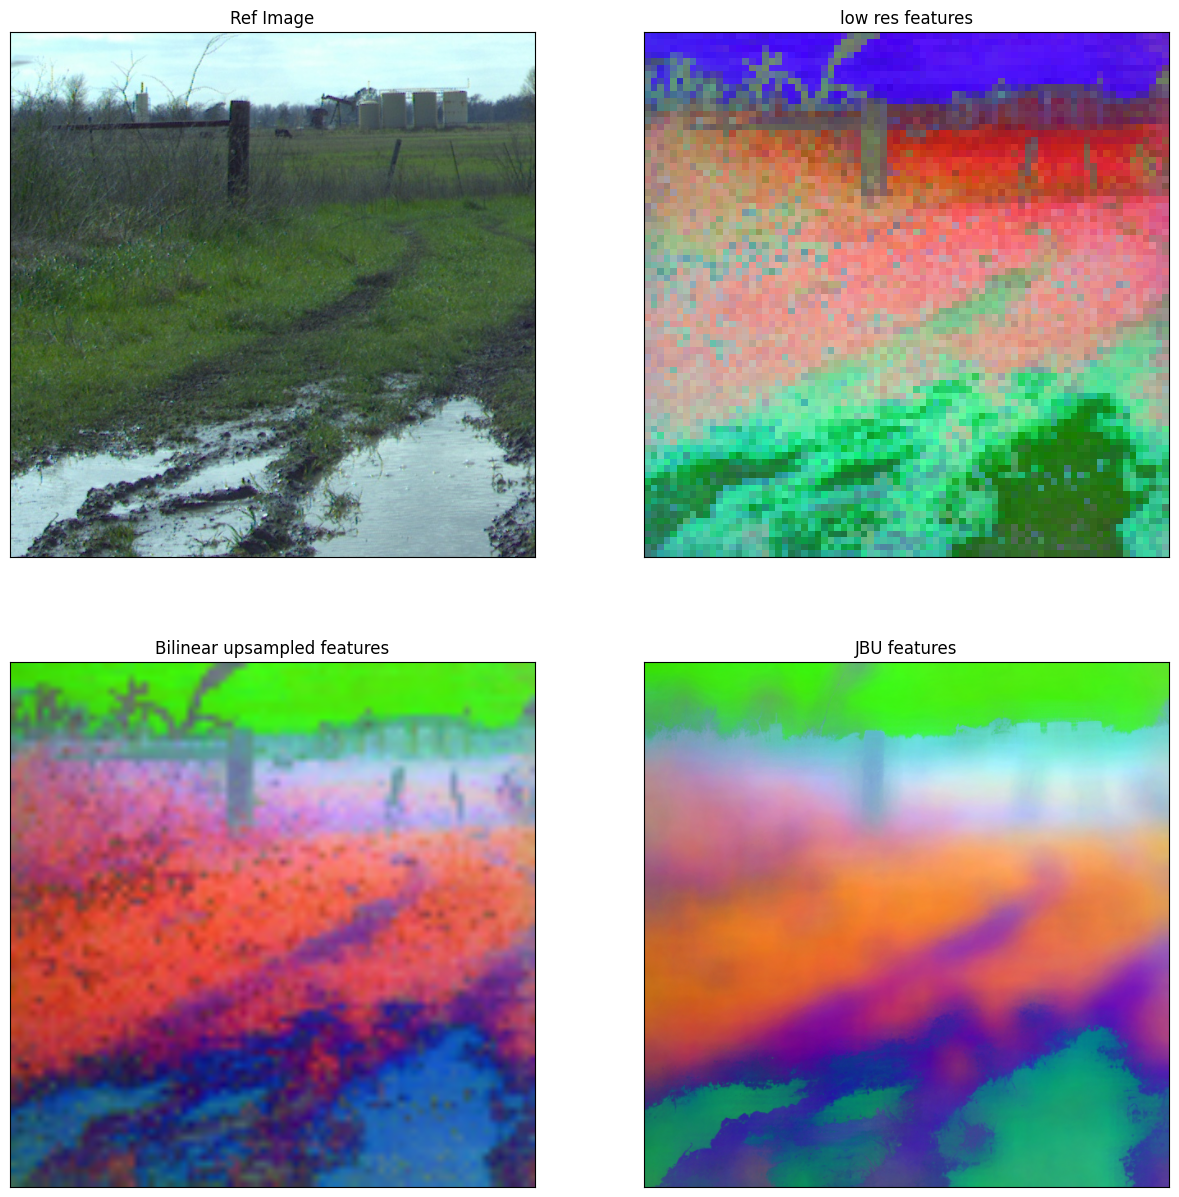

In [36]:
[lr_feats_pca], _ = pca([lr_feats])
[hr_feats_bili_pca], _ = pca([hr_feats_bili])
[hr_feats_jbu_pca], _ = pca([hr_feats.permute(2,0,1).unsqueeze(0)])

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0,0].imshow(v2.functional.to_pil_image(unnorm(image).squeeze(0)))
ax[0,0].set_title("Ref Image")
ax[0,1].imshow(v2.functional.to_pil_image(lr_feats_pca[0]))
ax[0,1].set_title("low res features")
ax[1,0].imshow(v2.functional.to_pil_image(hr_feats_bili_pca[0]))
ax[1,0].set_title("Bilinear upsampled features")
ax[1,1].imshow(v2.functional.to_pil_image(hr_feats_jbu_pca[0]))
ax[1,1].set_title("JBU features")
remove_axes(ax)
plt.show()

In [ ]:
dm = Rellis3d(
    data_path='/data',
    merge='all19',
    sup=2,
    unsup=5,
    train_tf=tf,
    test_tf=tf,
    batch_size_s=4,
    batch_size_u=4,
    steps_per_epoch=10,
    num_workers=0,
    pin_memory=False
)

In [ ]:
import torchvision.transforms.v2 as v2
import dl_toolbox.datasets as datasets
from torch.utils.data import Subset, RandomSampler
import torch
from dl_toolbox.utils import CustomCollate


transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

NB_IMG = 45*700
dataset = datasets.Resisc('/data/NWPU-RESISC45', transform, 'all45')
trainset = Subset(dataset, indices=[i for i in range(NB_IMG) if 100<=i%700])
valset = Subset(dataset, indices=[i for i in range(NB_IMG) if 100>i%700])

train_loader = torch.utils.data.DataLoader(
    trainset,
    collate_fn=CustomCollate(),
    num_workers=6,
    pin_memory=True,
    sampler=RandomSampler(
        trainset,
        replacement=True,
        num_samples=5000
    ),
    drop_last=True,
    batch_size=4,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    collate_fn=CustomCollate(),
    num_workers=6,
    pin_memory=True,
    shuffle=False,
    drop_last=True,
    batch_size=8,
)